In [81]:
import os
import matplotlib.pyplot as plt
import numpy as np

from scipy.ndimage import gaussian_filter
from scipy.ndimage import convolve
from scipy.ndimage import generate_binary_structure, label
from scipy.ndimage import sum as ndimage_sum

from astropy.io import fits
from astropy.table import Table
from astropy.stats import sigma_clipped_stats
from astropy.stats import mad_std
from scipy.signal import find_peaks


#f_name = "/work/vela/oca/fits/zb08/raw/1010/zb08c_1010_61684.fits"
#f_name = "/work/vela/oca/fits/zb08/raw/1010/zb08c_1010_54161.fits"
#f_name = "/work/vela/oca/fits/zb08/raw/1010/zb08c_1010_55698.fits"
f_name = "/work/vela/oca/fits/zb08/raw/1010/zb08c_1010_72970.fits"




In [82]:

hdul = fits.open(f_name)
image = hdul[0].data
header = hdul[0].header
hdul.close()

print(hdul)


In [83]:
def line_detection_kernel(R):
    size = 2 * R + 1
    center = R
    y, x = np.ogrid[:size, :size]
    distance = np.sqrt((x - center)**2 + (y - center)**2)
    inner = R - 1 / 2
    outer = R + 1 / 2

    left = ((x <= center) & (y <= center)) | ((x >= center) & (y >= center))
    right = ((x < center) & (y > center)) | ((x > center) & (y < center))
    
    #left
    mk = ((distance >= inner) & (distance <= outer))
    kernel_l = mk.astype(float)
    s = np.sum(mk)
    w = np.sum(~mk)
    #kernel_l[~mk] = -1 * (s/2) / (w - s - 1)
    #kernel_l[center,center]= 2
    tmp_mk = ((distance >= inner) & (distance <= outer) & right)
    kernel_l[tmp_mk] = -1
    
    #right
    mk = ((distance >= inner) & (distance <= outer))
    kernel_r = mk.astype(float)
    s = np.sum(mk)
    w = np.sum(~mk)
    #kernel_r[~mk] = -1 * (s/2) / (w - s - 1)
    #kernel_r[center,center]= 2
    tmp_mk = ((distance >= inner) & (distance <= outer) & left)
    kernel_r[tmp_mk] = -1

    #print(kernel_l, kernel_r)

    return kernel_l, kernel_r



19.273828840572826 19.273828840572826


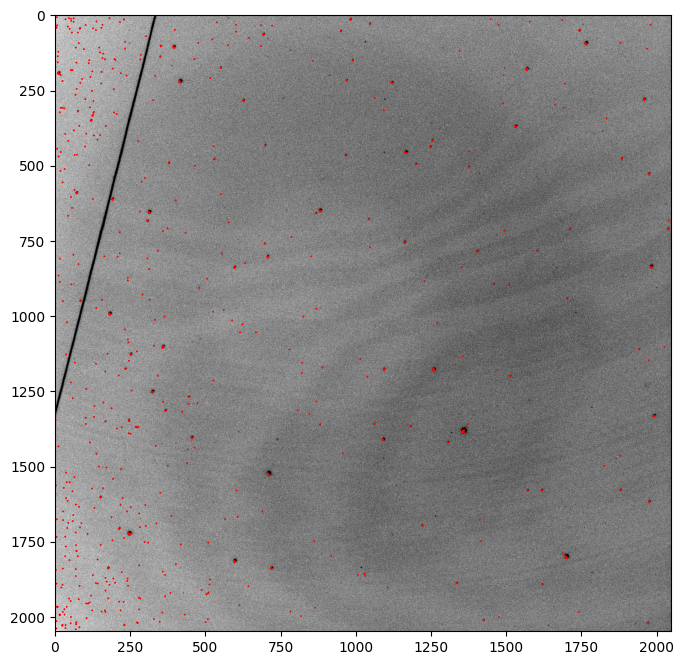

In [84]:
# sobel filter

kernel_max = 8
th = 3 * 4
kernel_sobel1 = [[-1,0,1],
                  [-2,0,2],
                  [-1,0,1]]

kernel_sobel2 = [[-1,-2,-1],
                  [0,0,0],
                  [1,2,-1]]


result_s1 = convolve(image, kernel_sobel1)
th_value1 = mad_std(image)
maska_ud = result_s1 > np.median(result_s1) + th * th_value1

result_s2 = convolve(image, kernel_sobel2)
th_value2 = mad_std(image)
maska_lr = result_s2 > np.median(result_s2) + th * th_value2

print(th_value1,th_value2)

maska_sobel = maska_ud | maska_lr

vmin = np.median(image)  - 1 * np.std(image)
vmax = np.median(image)  + 1 * np.std(image)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(image,vmin=vmin,vmax=vmax,cmap='binary')
X, Y = np.meshgrid(np.arange(image.shape[1]), np.arange(image.shape[0]))
countours = ax.contour(X, Y, maska_lr, 0, colors='red', linewidths=1) ##linewidth parameter had to be adjusted by eye estimation.

plt.show()


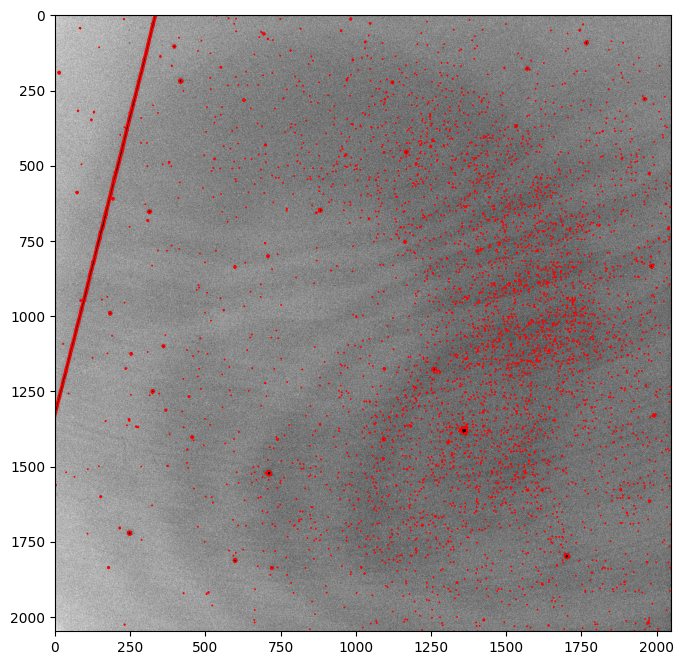

In [85]:
th = 3
maska_3s = image > np.median(image) + th * mad_std(image)

vmin = np.median(image)  - 1 * np.std(image)
vmax = np.median(image)  + 1 * np.std(image)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(image,vmin=vmin,vmax=vmax,cmap='binary')
X, Y = np.meshgrid(np.arange(image.shape[1]), np.arange(image.shape[0]))
countours = ax.contour(X, Y, maska_3s, 0, colors='red', linewidths=1) ##linewidth parameter had to be adjusted by eye estimation.

plt.show()

19.273828840572826 62.269293177235284
27159 957652 15400


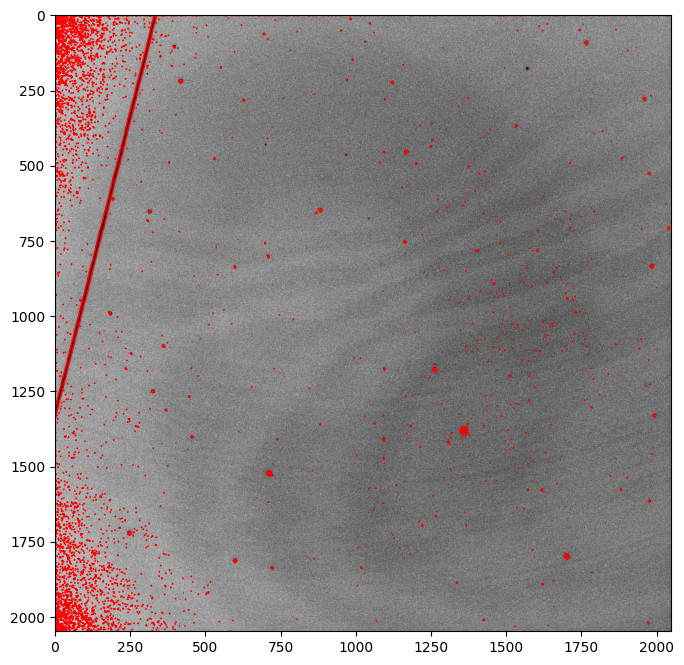

In [91]:
# filtr satelitow

th = 10


kernel_l,kernel_r = line_detection_kernel(1) # tu sie zmienia


result_l = convolve(image, kernel_l)
maska_l = result_l > np.median(result_l) +th * mad_std(image)

print(mad_std(image),mad_std(result_l))

result_r = convolve(image, kernel_r)
maska_r = result_r > np.median(result_r) + th * mad_std(image)

small_l = result_l
small_r = result_r

maska1 = maska_l ^ maska_r

kernel_l,kernel_r = line_detection_kernel(15) # tu sie zmienia

result_l = convolve(image, kernel_l)
maska_l = result_l > np.median(result_l) + th * mad_std(image)

result_r = convolve(image, kernel_r)
maska_r = result_r > np.median(result_r) + th * mad_std(image)

big_l = result_l
big_r = result_r

maska2 = maska_l ^ maska_r


maska_ld = maska1 & maska2


vmin = np.median(image)  - 1 * np.std(image)
vmax = np.median(image)  + 1 * np.std(image)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(image,vmin=vmin,vmax=vmax,cmap='binary')
X, Y = np.meshgrid(np.arange(image.shape[1]), np.arange(image.shape[0]))
countours = ax.contour(X, Y, maska_ld, 0, colors='red', linewidths=1) ##linewidth parameter had to be adjusted by eye estimation.

print(len(image[maska1]),len(image[maska2]),len(image[maska_ld]))

plt.show()



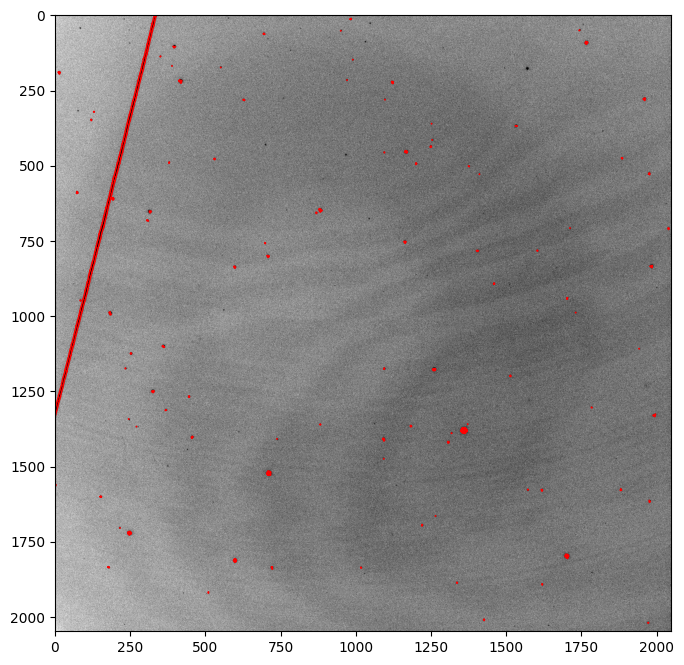

9062


In [92]:
maska = maska_ld & maska_3s

vmin = np.median(image)  - 1 * np.std(image)
vmax = np.median(image)  + 1 * np.std(image)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(image,vmin=vmin,vmax=vmax,cmap='binary')
X, Y = np.meshgrid(np.arange(image.shape[1]), np.arange(image.shape[0]))
countours = ax.contour(X, Y, maska, 0, colors='red', linewidths=1) ##linewidth parameter had to be adjusted by eye estimation.

plt.show()

print(len(image[maska]))



In [93]:
def hough_transform(image, maska, steps=180):
    ys,xs = np.nonzero(maska)
    xs = xs.astype(float)
    ys = ys.astype(float)
    N = len(xs)

    ny,nx = image.shape
    rh0 = int((ny**2+nx**2)**0.5)

    tht = np.deg2rad(np.linspace(-90, 90, steps))
    T = len(tht)

    cos_t = np.cos(tht)
    sin_t = np.sin(tht)

    rho_mtx = xs[:,None] * cos_t[None,:] + ys[:,None] * sin_t[None,:]

    rh = np.linspace(-rh0, rh0, 2*rh0)

    ri = np.round(rho_mtx+rh0).astype(int)

    accumulator = np.zeros((len(rh),T))

    ri_flat = ri.ravel()
    ti_flat = np.tile(np.arange(T),N)

    np.add.at(accumulator, (ri_flat,ti_flat), 1)

    return accumulator, tht, rh


def hough_transform2(image, maska, steps=180):
    ys,xs = np.nonzero(maska)
    ny,nx = image.shape
    tht = np.deg2rad(np.linspace(-90, 90, steps))
    rh0 = int((ny**2+nx**2)**0.5)
    rh = np.linspace(-rh0, rh0, 2*rh0)

    accumulator = np.zeros((len(rh),len(tht)))

    for x,y in zip(ys,xs):
        for ti,t in enumerate(tht):
            r = x * np.cos(t) + y * np.sin(t)
            ri = int(r+rh0)
            accumulator[ri,ti] += 1

    return accumulator, tht, rh


H,tht,rh = hough_transform(image,maska_3s)







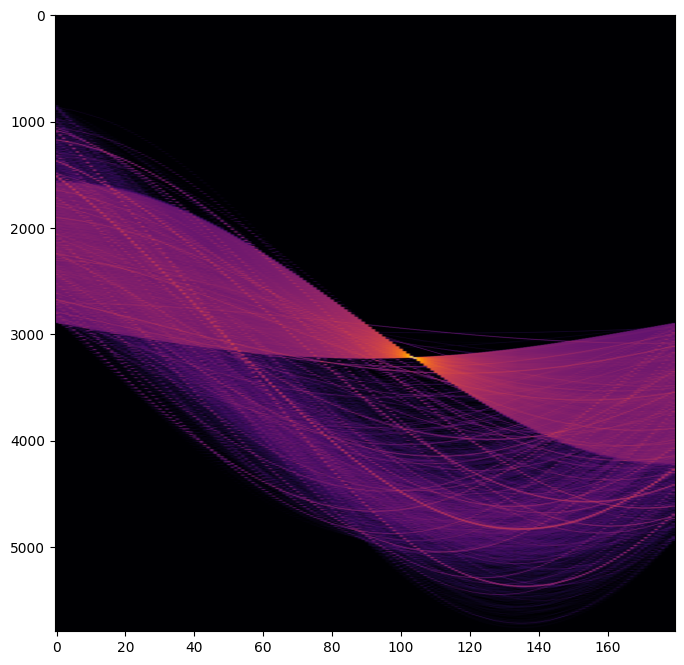

In [102]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(np.log1p(H),aspect="auto",cmap='inferno')

plt.show()

In [98]:
from scipy.signal import find_peaks

Hf = H.max(axis=1)


print(np.mean(H),np.std(H),np.mean(H)+3*np.std(H),np.max(H))

peaks, _ = find_peaks(Hf, height=100)

lines_rho = []
lines_theta = []
lines_val = []
for p in peaks:
    rho = rh[p]
    ti = np.argmax(H[p])
    t = tht[ti]
    val = H[p,ti]
    tmp = {}
    lines_rho.append(rho)
    lines_theta.append(t)
    lines_val.append(val)

print(len(lines_rho))
print(max(lines_val))

2.6268991712707184 6.662412261837169 22.614135956782224 859.0
26
859.0


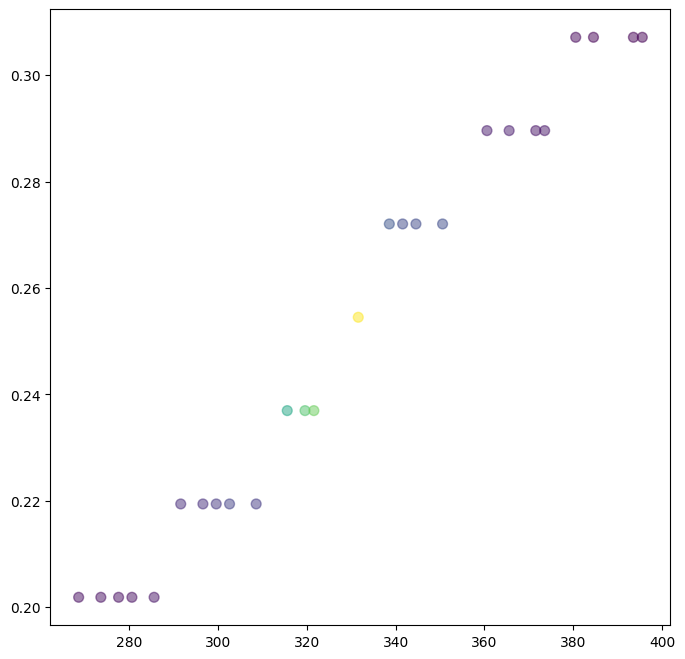

In [99]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(lines_rho,lines_theta,c=lines_val,s=50,alpha=0.5)
plt.show()

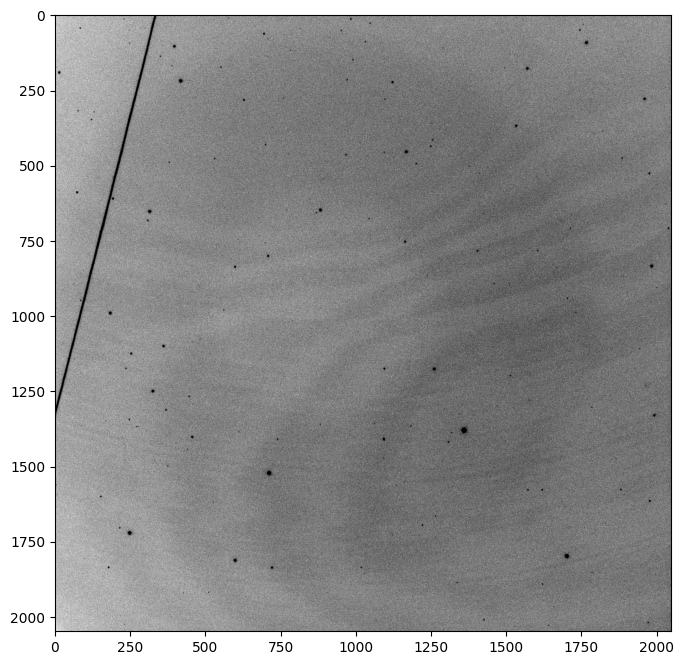

In [97]:
vmin = np.median(image)  - 1 * np.std(image)
vmax = np.median(image)  + 1 * np.std(image)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(image,vmin=vmin,vmax=vmax,cmap='binary')
for r,t,v in zip(lines_rho,lines_theta,lines_val):
    if v > 2000:
        r = r
        t = t

        yl = np.arange(image.shape[0])
        xl = (r - yl * np.sin(t))/np.cos(t)

        mk1 = xl > 0
        mk2 = xl < image.shape[1]

        mk = mk1 & mk2

        xl = xl[mk]
        yl = yl[mk]

        ax.plot(xl,yl,"r-",alpha=0.1,linewidth=5)

plt.show()